## Functions to put all Feather River data for each WSN into tables
Ignoring nodes 7 and 11 for GRZL, 3 for KTL since they have some missing sensor types

In [3]:
import numpy as np
from ModelTest import *
import pandas as pd
from Utilities import obsFrac, getMidnightNoonIdx
from SSMTools import *
import datetime

In [4]:
colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]

In [9]:
# Info on what's available
feather_wsns = ["KTL", "GRZL"]
feather_sensortypes = {"HS": "snowdepth", "RH": "rel_humidity", "Tair": "air_temp"}

# List of sensors to load data for
feather_n_sensors = 12
feather_sensors = [s for s in range(1, feather_n_sensors+1) if s not in [7, 11]] # specify sensors to exclude here

# Used to correct sensors with lagged timestamps
feather_laggy_sensors = ["snowdepth_4", "snowdepth_8", "snowdepth_9"]

# Used to figure out range of observation times
min_datetime = datetime.datetime(9999, 1, 1)
max_datetime = datetime.datetime(1, 1, 1)

raw_data = {}

In [17]:
## Load all the data
site_name = feather_wsns[1]

for s in feather_sensors:
    raw_data[s] = {}
    
    for stype in feather_sensortypes:
        # Load the raw data
        df_raw = pd.read_csv("../raw_data/feather/%s/%s/Node%i.csv"%(site_name, stype, s), delimiter=";")
        
        # Type of sensor data
        sensor_type = feather_sensortypes[stype]
        
        # Change column names and data types
        if len(df_raw.columns) != 2:
            print s, sensor_type, df_raw.columns
        df_raw.columns = ["time", sensor_type + "_%i"%s]
        df_raw["time"] = pd.to_datetime(df_raw["time"])
        # Round times that are off by a minute or second
        for i, t in df_raw["time"].iteritems():
            rounded = False
            # Round seconds
            if 30 < t.second <= 59:
                t = t.replace(minute=t.minute+1).replace(second=0)
                rounded = True
            elif 1 <= t.second <= 30:
                t = t.replace(second=0)
                rounded = True
            # Round to nearest 5 minutes
            if t.minute % 5 != 0:
                t = t.replace(minute=int(5*round(float(t.minute)/5)) % 60)
                rounded = True
            
            if rounded:
                df_raw.set_value(i, "time", t)
        
        # Convert data column to be numeric
        df_raw[sensor_type + "_%i"%s] = pd.to_numeric(df_raw[sensor_type + "_%i"%s], errors="coerce")
        
        # Save the raw data
        raw_data[s][sensor_type] = df_raw
        
        # Check if there are earlier or later observation times than those already seen in this data
        min_datetime = min(min_datetime, df_raw["time"].min())
        max_datetime = max(max_datetime, df_raw["time"].max())

In [18]:
# Put everything into a table
df_feather = pd.DataFrame(columns=["time"] + [v + "_%i"%s for v in feather_sensortypes.values() for s in feather_sensors])
df_feather["time"] = pd.date_range(start=min_datetime, end=max_datetime, freq="15min")

In [19]:
# For each node
for s in feather_sensors:
    # For each sensor type
    for stype in feather_sensortypes.itervalues():
        # Loop over observation times
        for i, row in raw_data[s][stype].iterrows():
            if row[stype + "_%i"%s] == pd.NaT:
                print "NaT", s, stype, row["time"]
                
            # Find observation's row in master table
            row_idx = np.where(df_feather["time"] == row["time"])[0][0]
            
            # Insert observation if there was one
            if not pd.isnull(row[stype + "_%i"%s]):
                df_feather.set_value(row_idx, stype + "_%i"%s, row[stype + "_%i"%s])

In [20]:
df_feather.to_csv("../output/feather/" + site_name.lower() + ".csv", header=True)

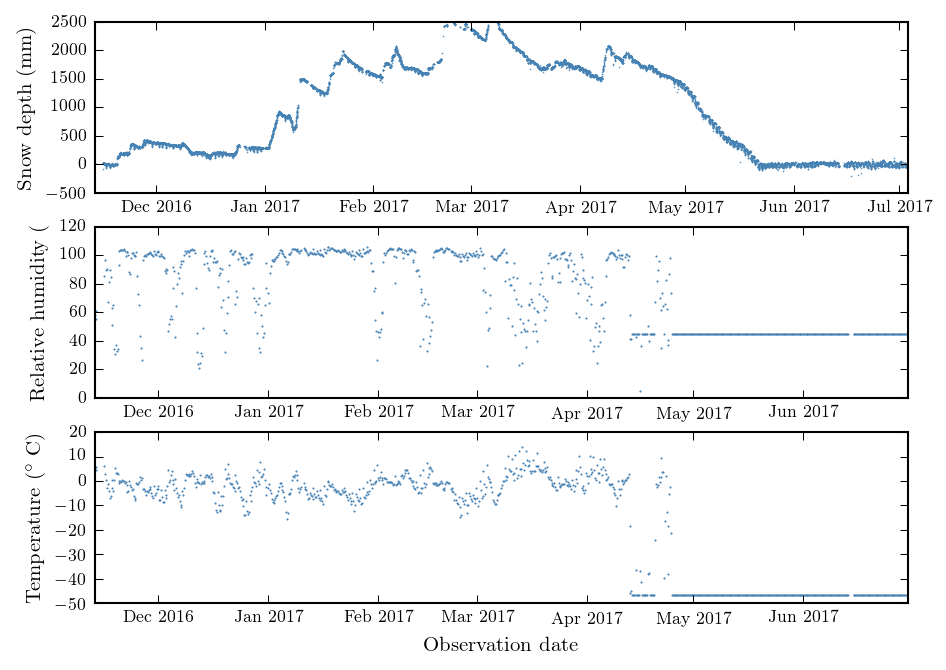

In [21]:
plt.figure(figsize=(7, 5))

sensor = 1

plt.subplot(3, 1, 1)
plt.plot(df_feather["time"].values, df_feather["snowdepth_%i"%sensor].values, '.', markersize=0.5)
plt.ylabel("Snow depth (mm)")

plt.subplot(3, 1, 2)
plt.plot(df_feather["time"].values, df_feather["rel_humidity_%i"%sensor], '.', markersize=1)
plt.ylabel("Relative humidity (%)")

plt.subplot(3, 1, 3)
plt.plot(df_feather["time"].values, df_feather["air_temp_%i"%sensor].values, '.', markersize=1)
plt.xlabel("Observation date")
plt.ylabel(r"Temperature ($^\circ$ C)")